Tensorflow 1.4.0 is required.
This is based on [NMT Tutorial](https://github.com/tensorflow/nmt).

In [0]:
import numpy as np
import tensorflow as tf
from __future__ import print_function
from tensorflow.python.layers import core as layers_core
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt
from random import randint

## Note for me. You've summarized Seq2Seq at http://d.hatena.ne.jp/higepon/20171210/1512887715.

In [2]:
tf.__version__
!mkdir "./saved_model2"
!mkdir "./saved_model"


!ls -la ./saved_model2

mkdir: cannot create directory ‘./saved_model2’: File exists
mkdir: cannot create directory ‘./saved_model’: File exists
total 12
drwxr-xr-x  3 root root 4096 Dec 22 01:23 .
drwxr-xr-x 13 2000 2000 4096 Dec 22 01:23 ..
drwxr-xr-x  2 root root 4096 Dec 22 01:23 hige


In [0]:
# TODO
# Make 2 models possible
# Make them as methods
# Change first part to use small hparams for debug
# We could pass sequence_length to tf.nn.dynamic_rnn for better performance.
# Maybe extract hparams
# モデル どうやって reload するか？
# support beam infer
# attention default
# model_path による reload が動いて得ない。

test_hparams = tf.contrib.training.HParams(
    batch_size=3,
    encoder_length=5,
    decoder_length=5,
    num_units=6,
    vocab_size=9,
    embedding_size=8,
    learning_rate = 0.01,
    max_gradient_norm = 5.0,
    beam_width =9,
    use_attention = False,
    num_train_steps = 150,
    debug_verbose = False
)

real_hparams = tf.contrib.training.HParams(
    batch_size=25, # of tweets should be devidable by batch_size
    encoder_length=20, 
    decoder_length=20,
    num_units=1024,
    vocab_size=500,
    embedding_size=256,
    learning_rate = 0.01,
    max_gradient_norm = 5.0,
    beam_width =9,
    use_attention = False,
    num_train_steps = 100,
    debug_verbose = True
)

# Model path
model_path = "./saved_model/twitter"

# Symbol for start decode process.
tgt_sos_id = 0

# Symbol for end of decode process.
tgt_eos_id = 1

pad_id = 2

unk_id = 3

In [0]:
# For debug purpose.
tf.reset_default_graph()

class ChatbotModel:
  def __init__(self, sess, hparams, model_path, scope='ChatbotModel'):
    self.sess = sess
    # todo remove
    self.hparams = hparams
    
    # todo
    self.model_path = model_path
    self.name = scope

    self.encoder_inputs, encoder_outputs, encoder_state, embedding_encoder = self._build_encoder(hparams, scope)
    self.decoder_inputs, self.decoder_lengths, self.replies, self.beam_replies, logits, self.infer_logits = self._build_decoder(hparams, embedding_encoder, encoder_state, encoder_outputs, scope)

    self.reward = tf.placeholder(tf.float32, name="reward")
    self.target_labels, self.loss, self.global_step, self.train_op = self._build_optimizer(hparams, logits)
    
    # Initialize saver after model created
    self.saver = tf.train.Saver(tf.global_variables())

    ckpt = tf.train.get_checkpoint_state(self.model_path)
    if ckpt:
      last_model = ckpt.model_checkpoint_path
      self.saver.restore(self.sess, last_model)
      print("loaded " + last_model)
    else:
      self.sess.run(tf.global_variables_initializer())
      print("created fresh model.")
      
  def train(self, encoder_inputs, target_labels, decoder_inputs, decoder_lengths):
    feed_dict = {
        self.encoder_inputs: encoder_inputs,
        self.target_labels: target_labels,
        self.decoder_inputs: decoder_inputs,
        self.decoder_lengths: decoder_lengths,
        # For normal Seq2Seq reward is always 1.
        self.reward: 1.0 
    }    
    _, loss_value, global_step = self.sess.run([self.train_op, self.loss, self.global_step], feed_dict=feed_dict)
    return loss_value, global_step

  # How to implemen this
  #  (1) Infer by training input.
  #  (2) Get the output
  #  (3) Pass the output to normal another Seq2Seq and calculate reward.
  #  (4) train_with_rewards
  #  (4) Then traning with the adjusted loss.  
  def train_with_reward(self, standard_seq2seq_model, encoder_inputs, target_labels, decoder_inputs, decoder_lengths, dull_responses):
    infered_replies = self.infer(encoder_inputs)
    standard_seq2seq_encoder_inputs =[]
    for reply in infered_replies:
      if len(reply) <= self.hparams.encoder_length:
        standard_seq2seq_encoder_inputs.append(np.append(reply, ([pad_id] * (self.hparams.encoder_length - len(reply)))))
      else:
        raise Exception("Infered reply is not suppose to be longer than encoder_input")
    standard_seq2seq_encoder_inputs = np.transpose(np.array(standard_seq2seq_encoder_inputs))
    reward = standard_seq2seq_model.reward_ease_of_answering(standard_seq2seq_encoder_inputs, dull_responses)
    print(reward)
  
  def infer(self, encoder_inputs):
    inference_feed_dict = {
        self.encoder_inputs: encoder_inputs,
    }
    replies = self.sess.run(self.replies, feed_dict=inference_feed_dict)
    return replies
  
  def infer_beam_search(self, encoder_inputs):
    inference_feed_dict = {
        self.encoder_inputs: encoder_inputs,
    }    
    replies = self.sess.run(self.beam_replies, feed_dict=inference_feed_dict)
    return replies
  
  ## todo model_path
  def save(self):
      self.saver.save(self.sess, "{}/{}".format(self.model_path, self.name), global_step=self.global_step)
      
  def log_prob(self, encoder_inputs, expected_output):
    """Return sum of log probability of given one specific expected_output for sencoder_inputs.

    Args:
        encoder_inputs: [encoder_length, batch_size], eg) tweets
        expected_output: [1, decoder_length or less than decoder_length], eg) One reply.

    Returns:
        Return log probablity of expected output for given encoder inputs.
        eg) sum of log probability of reply "Good" when given ["How are you?", "What's up?"]
    """
    inference_feed_dict = {
      self.encoder_inputs: encoder_inputs,
    }
    
    # Logits
    #   logits_value: [batch_size, actual_decoder_length, vocab_size]
    logits_batch_value = self.sess.run(self.infer_logits, feed_dict=inference_feed_dict)

    sum_p = []
    # For each batch: [actual_decoder_length, vocab_size]
    for logits in logits_batch_value:
      p = 1
      # Note that expected_output and logits don't always have same length, but zip takes care of the case.
      for word_id, logit in zip(expected_output, logits):
        # Apply softmax first, see definition of softmax.
        norm = (self._softmax(logit))[word_id]
        p *= norm
      p = np.log(p)
      sum_p.append(p)
    ret = np.sum(sum_p) / len(sum_p)
    return ret  
  
  def reward_ease_of_answering(self, encoder_inputs, expected_outputs):
    """ Return reward for ease of answering. See Deep Reinforcement Learning for Dialogue Generation for more details.

    Args:
        encoder_inputs: [encoder_length, batch_size], eg) tweets
        expected_outputs: [number of pre-defined dull responses, decoder_length or less than decoder_length]. eg) [["I'm", "Good"], ["fine"]]

    Returns:
        Return reward for ease of answering.
        Note that this can be calcualated by calling log_prob function for each dull response,
        but this function is more efficient because this calculated the reward at once.
    """    
    inference_feed_dict = {
      self.encoder_inputs: encoder_inputs,
    }
    
    # Logits
    #   logits_value: [batch_size, actual_decoder_length, vocab_size]
    logits_batch_value = self.sess.run(self.infer_logits, feed_dict=inference_feed_dict)

    batch_sum_p = []
    # For each batch: [actual_decoder_length, vocab_size]
    for logits in logits_batch_value:
      sum_p = []
      for expected_output in expected_outputs:
        p = 1
        # Note that expected_output and logits don't always have same length, but zip takes care of the case.
        for word_id, logit in zip(expected_output, logits):
          # Apply softmax first, see definition of softmax.
          norm = (self._softmax(logit))[word_id]
          p *= norm
        p = np.log(p) / len(expected_output)
        sum_p.append(p)
      one_batch_p = np.sum(sum_p)
      batch_sum_p.append(one_batch_p)
    ret = np.sum(batch_sum_p) / len(batch_sum_p)
    return -ret  
      
    
  @staticmethod
  def _softmax(x):
      return np.exp(x) / np.sum(np.exp(x), axis=0)
      
  def _build_optimizer(self, hparams, logits):
    # Target labels
    #   As described in doc for sparse_softmax_cross_entropy_with_logits,
    #   labels should be [batch_size, decoder_lengths] instead of [batch_size, decoder_lengths, vocab_size].
    #   So labels should have indices instead of vocab_size classes.
    target_labels = tf.placeholder(tf.int32, shape=(hparams.batch_size, hparams.decoder_length), name="target_labels")

    # Loss
    crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=target_labels, logits=logits)

    loss = tf.reduce_sum(crossent / tf.to_float(hparams.batch_size))
    # Adjust loss with reward.
    loss = tf.multiply(loss, self.reward)
    
    # Train
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Calculate and clip gradients
    params = tf.trainable_variables()
    gradients = tf.gradients(loss, params)
    clipped_gradients, _ = tf.clip_by_global_norm(
        gradients, hparams.max_gradient_norm)

    # Optimization
    optimizer = tf.train.AdamOptimizer(hparams.learning_rate)
    train_op = optimizer.apply_gradients(
        zip(clipped_gradients, params), global_step=global_step)
    return target_labels, loss, global_step, train_op
  
  def _build_encoder(self, hparams, scope):
    # Encoder
    #   encoder_inputs: [encoder_length, batch_size]
    #   This is time major where encoder_length comes first instead of batch_size.
    encoder_inputs = tf.placeholder(tf.int32, shape=(hparams.encoder_length, hparams.batch_size), name="encoder_inputs")
    
    # Embedding
    #   We originally didn't share embbedding between encoder and decoder.
    #   But now we share it. It makes much easier to calculate rewards.
    #   Matrix for embedding: [vocab_size, embedding_size]
    with tf.variable_scope(scope):
      embedding_encoder = tf.get_variable("embedding_encoder", [hparams.vocab_size, hparams.embedding_size])

    # Look up embedding:
    #   encoder_inputs: [encoder_length, batch_size]
    #   encoder_emb_inputs: [encoder_length, batch_size, embedding_size]
    encoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder, encoder_inputs)

    # LSTM cell.
    with tf.variable_scope(scope):
      encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)

    # Run Dynamic RNN
    #   encoder_outputs: [encoder_length, batch_size, num_units]
    #   encoder_state: [batch_size, num_units], this is final state of the cell for each batch.
    with tf.variable_scope(scope):
      encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, encoder_emb_inputs, time_major=True, dtype=tf.float32)
      
    return encoder_inputs, encoder_outputs, encoder_state, embedding_encoder
  
  def _build_decoder(self, hparams, embedding_encoder, encoder_state, encoder_output, scope):
    # Decoder input
    #   decoder_inputs: [decoder_length, batch_size]
    #   decoder_lengths: [batch_size]
    #   This is grand truth target inputs for training.
    decoder_inputs = tf.placeholder(tf.int32, shape=(hparams.decoder_length, hparams.batch_size), name="decoder_inputs")
    decoder_lengths = tf.placeholder(tf.int32, shape=(hparams.batch_size), name="decoder_lengths")

    # Look up embedding:
    #   decoder_inputs: [decoder_length, batch_size]
    #   decoder_emb_inp: [decoder_length, batch_size, embedding_size]
    decoder_emb_inputs = tf.nn.embedding_lookup(embedding_encoder, decoder_inputs)   
    
    # https://stackoverflow.com/questions/39573188/output-projection-in-seq2seq-model-tensorflow
    # Internally, a neural network operates on dense vectors of some size,
    # often 256, 512 or 1024 floats (let's say 512 for here). 
    # But at the end it needs to predict a word from the vocabulary which is often much larger,
    # e.g., 40000 words. Output projection is the final linear layer that converts (projects) from the internal representation to the larger one.
    # So, for example, it can consist of a 512 x 40000 parameter matrix and a 40000 parameter for the bias vector.
    projection_layer = layers_core.Dense(hparams.vocab_size, use_bias=False)
    
    helper = tf.contrib.seq2seq.TrainingHelper(decoder_emb_inputs, decoder_lengths, time_major=True)

    # Decoder with helper:
    #   decoder_emb_inputs: [decoder_length, batch_size, embedding_size]
    #   decoder_length: [batch_size] vector, which represents each target sequence length.
    decoder_cell = tf.nn.rnn_cell.BasicLSTMCell(hparams.num_units)

    if hparams.use_attention:
      # Attention
      # attention_states: [batch_size, max_time, num_units]
      attention_states = tf.transpose(self.encoder_outputs, [1, 0, 2])

      # Create an attention mechanism
      attention_mechanism = tf.contrib.seq2seq.LuongAttention(
          hparams.num_units, attention_states,
          memory_sequence_length=None)

      decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
          decoder_cell, attention_mechanism,
          attention_layer_size=hparams.num_units)

      initial_state = decoder_cell.zero_state(hparams.batch_size, tf.float32).clone(cell_state=encoder_state)
    else:
      initial_state = encoder_state    
      
    # Decoder and decode
    decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, helper, initial_state,
        output_layer=projection_layer)

    # Dynamic decoding
    #   final_outputs.rnn_output: [batch_size, decoder_length, vocab_size], list of RNN state.
    #   final_outputs.sample_id: [batch_size, decoder_length], list of argmax of rnn_output.
    #   final_state: [batch_size, num_units], list of final state of RNN on decode process.
    #   final_sequence_lengths: [batch_size], list of each decoded sequence. 
    final_outputs, _final_state, _final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(decoder)

    if hparams.debug_verbose:
      print("rnn_output.shape=", final_outputs.rnn_output.shape)
      print("sample_id.shape=", final_outputs.sample_id.shape)
      print("final_state=", _final_state)
      print("final_sequence_lengths.shape=", _final_sequence_lengths.shape)

    logits = final_outputs.rnn_output    
    
    # Inference
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
        embedding_encoder,
        tf.fill([hparams.batch_size], tgt_sos_id), tgt_eos_id)

    # Inference Decoder
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, inference_helper, initial_state,
        output_layer=projection_layer)

    # len(infered_reply) is lte encoder_length, because we are targetting tweeet (140 for each tweet)
    # Also by doing this, we can pass the reply to other seq2seq w/o shorten it.
    maximum_iterations = hparams.encoder_length

    # Dynamic decoding
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
        inference_decoder, maximum_iterations=maximum_iterations)
    replies = outputs.sample_id
    
    # We use infer_logits instead of logits when calculating log_prob, because infer_logits doesn't require decoder_lengths input.
    infer_logits = outputs.rnn_output

    # Beam Search
    # Replicate encoder infos beam_width times
    decoder_initial_state = tf.contrib.seq2seq.tile_batch(
        initial_state, multiplier=hparams.beam_width)

    # Define a beam-search decoder
    inference_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
            cell=decoder_cell,
            embedding=embedding_encoder,
            start_tokens=tf.fill([hparams.batch_size], tgt_sos_id),
            end_token=tgt_eos_id,
            initial_state=decoder_initial_state,
            beam_width=hparams.beam_width,
            output_layer=projection_layer,
            length_penalty_weight=0.0)

    # Dynamic decoding
    beam_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
        inference_decoder, maximum_iterations=maximum_iterations)
    beam_replies = beam_outputs.predicted_ids    

    return decoder_inputs, decoder_lengths, replies, beam_replies, logits, infer_logits

In [0]:
# Helper functions to test
def make_test_training_data(hparams):
  train_encoder_inputs = np.empty((hparams.encoder_length, hparams.batch_size), dtype=np.int)
  training_target_labels = np.empty((hparams.batch_size, hparams.decoder_length), dtype=np.int)
  training_decoder_inputs = np.empty((hparams.decoder_length, hparams.batch_size), dtype=np.int)

  # We keep first tweet to validate inference.
  first_tweet = None

  for i in range(hparams.batch_size):
    # Tweet
    tweet = np.random.randint(low=0, high=hparams.vocab_size, size=hparams.encoder_length)
    train_encoder_inputs[:, i] = tweet  
  
    # Reply
    #   Note that low = 2, as 0 and 1 are reserved.
    reply = np.random.randint(low=2, high=hparams.vocab_size, size=hparams.decoder_length - 1)
  
    training_target_label = np.concatenate((reply, np.array([tgt_eos_id])))
    training_target_labels[i] = training_target_label
  
    training_decoder_input = np.concatenate(([tgt_sos_id], reply))
    training_decoder_inputs[:, i] = training_decoder_input
  
    if i == 0:
      first_tweet = tweet
      if hparams.debug_verbose:
        print("0th tweet={}".format(tweet))
        print("0th reply_with_eos_suffix={}".format(training_target_label))
        print("0th reply_with_sos_prefix={}".format(training_decoder_input))

    if hparams.debug_verbose:
      print("Tweets")
      print(train_encoder_inputs)
      print("Replies")
      print(training_target_labels)
      print(training_decoder_inputs)
  return first_tweet, train_encoder_inputs, training_target_labels, training_decoder_inputs

def test_training(test_hparams, model):
  print("==== training model ====")
  first_tweet, train_encoder_inputs, training_target_labels, training_decoder_inputs = make_test_training_data(test_hparams)
  # Train
  x = []
  y = []
  for i in range(test_hparams.num_train_steps):
    loss_value, global_step = model.train(train_encoder_inputs, training_target_labels, training_decoder_inputs, np.ones((test_hparams.batch_size), dtype=int) * test_hparams.decoder_length)
    if i % 5 == 0 and test_hparams.debug_verbose:
      print('.', end='')

    if i % 15 == 0:
      model.save()
      x.append(global_step)
      y.append(loss_value)
      if test_hparams.debug_verbose:
        print("loss={} step={}".format(loss_value, global_step))

  inference_encoder_inputs = np.empty((test_hparams.encoder_length, test_hparams.batch_size), dtype=np.int)
  for i in range(test_hparams.batch_size):
    inference_encoder_inputs[:, i] = first_tweet


  # testing 
  log_prob54 = model.log_prob(inference_encoder_inputs, np.array([5, 4]))
  log_prob65 = model.log_prob(inference_encoder_inputs, np.array([6, 5]))
  print("log_prob for 54", log_prob54)
  print("log_prob for 65", log_prob65)

  reward = model.reward_ease_of_answering(inference_encoder_inputs, np.array([[5], [6]]))
  print("reward=", reward)
  
  if test_hparams.debug_verbose:
    print(inference_encoder_inputs)
  replies = model.infer(inference_encoder_inputs)
  print("Infered replies", replies[0])
  print("Expected replies", training_target_labels[0])
  
  beam_replies = model.infer_beam_search(inference_encoder_inputs)
  print("Infered replies candidate0", beam_replies[0][:,0])
  print("Infered replies candidate1", beam_replies[0][:,1])

  if test_hparams.debug_verbose:    
    plt.plot(x, y, label="Loss")
    plt.plot()
    plt.xlabel("Loss")
    plt.ylabel("steps")
    plt.legend()
    plt.show()
  
def test_two_models_training():
  first_tweet, train_encoder_inputs, training_target_labels, training_decoder_inputs = make_test_training_data(test_hparams)

  graph1= tf.Graph()
  graph2 = tf.Graph()

  with graph1.as_default():
    sess1 = tf.Session(graph=graph1)
    model = ChatbotModel(sess1, test_hparams, model_path="./saved_model/hige")
    test_training(test_hparams, model)  

  with graph2.as_default():
    sess2 = tf.Session(graph=graph2)
    model2 = ChatbotModel(sess2, test_hparams, model_path="./saved_model2/hige")
    test_training(test_hparams, model2)  
    dull_responses = [[4, 6, 6], [5, 5]]
    model2.train_with_reward(model, train_encoder_inputs, training_target_labels, training_decoder_inputs, np.ones((test_hparams.batch_size), dtype=int) * test_hparams.decoder_length, dull_responses)

  


In [22]:
! rm -rf ./saved_model
! mkdir ./saved_model
! rm -rf ./saved_model2
! mkdir ./saved_model2

# Fresh model
test_two_models_training()

# Saved model
test_two_models_training()


created fresh model.
==== training model ====
log_prob for 54 -6.57202422497
log_prob for 65 -14.7492445807
reward= 16.8286383928
Infered replies [4 8 7 2 1]
Expected replies [4 8 7 2 1]
Infered replies candidate0 [4 8 7 2 1]
Infered replies candidate1 [4 5 7 2 1]
created fresh model.
==== training model ====
log_prob for 54 -4.58980307162
log_prob for 65 -13.3352072769
reward= 6.37157379349
Infered replies [5 2 8 2 1]
Expected replies [5 2 8 2 1]
Infered replies candidate0 [5 2 8 2 1]
Infered replies candidate1 [5 2 8 8 2]
8.04121222941
INFO:tensorflow:Restoring parameters from ./saved_model/hige/ChatbotModel-136
loaded ./saved_model/hige/ChatbotModel-136
==== training model ====
log_prob for 54 -17.5553426126
log_prob for 65 -9.98088790466
reward= 11.4933188261
Infered replies [3 6 8 3 1]
Expected replies [3 6 8 3 1]
Infered replies candidate0 [3 6 8 3 1]
Infered replies candidate1 [ 3  1 -1 -1 -1]
INFO:tensorflow:Restoring parameters from ./saved_model2/hige/ChatbotModel-136
loaded 

In [14]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline



KeyboardInterrupt: ignored

In [8]:
def read_file_from_drive(file_name):
  seq2seq_data_dir_id = "146ZLldWXLDH0l9WbSUNFKi3nVK_HV0Sz"
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(seq2seq_data_dir_id)}).GetList()
  found = [file for file in file_list if file['title'] == file_name]
  if found != []:
    downloaded = drive.CreateFile({'id': found[0]['id']})
    return downloaded.GetContentString()
  else:
    raise ValueError("file {} not found.".format(file_name))

def read_vocabulary_drive(vocabulary_path):
  rev_vocab = []
  rev_vocab.extend(read_file_from_drive(vocabulary_path).splitlines())
  print(rev_vocab)
  rev_vocab = [line.strip() for line in rev_vocab]
  vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
  return vocab, rev_vocab  
  
print(read_vocabulary_drive('vocab.txt'))

[u'_GO', u'_EOS', u'_PAD', u'_UNK', u'\uff01', u'\u306e', u'\u3066', u'0', u'\u3001', u'\u306b', u'\u305f', u'\u3067', u'\u304c', u'\u306f', u'\u3092', u'\u2026', u'\u3057', u'\u3002', u'\u3082', u'#', u'\u3067\u3059', u'\u307e\u3059', u'\u306d', u')', u'\u3068', u'(', u'\u306a', u'00', u'\u306a\u3044', u'\u3093', u'www', u'\u30fb', u'\u304b\u3089', u'\u3060', u'\u3088', u'\u304b', u'\uff1f', u'\u307e\u3067', u'rt', u'\u3055\u3093', u'\u3054', u'\u65e5', u'\u62bd\u9078', u'\u30d5\u30a9\u30ed\u30fc', u'/', u'\u306e\u3067', u'\u4e2d', u'\u3042\u308a\u304c\u3068\u3046', u'\u6bce\u65e5', u'\u3059\u308b', u'\u671d', u'000', u'\u03c9', u'\u30fc', u'\uff3c', u'\uff0f', u'\u540d', u'\u69d8', u'\u3054\u3056\u3044', u'\u5f53\u305f\u308b', u'\U0001f34b', u'\u3063\u3066', u'\u304a', u'\u307e\u3057', u'\u5fdc\u52df', u'\u300c', u'\u3051\u3069', u'\uff06', u'\u3053\u306e', u'\u6295\u7a3f', u'\u300d', u'w', u'\u3042\u3068', u'\u305d\u306e', u'\u3046', u'\u304f\u3060\u3055\u3044', u'\u3066\u308b', u'\

In [9]:
def read_training_data_from_drive(file_name, max_line_len, pad_value):
  ret = []
  for line in read_file_from_drive(file_name).splitlines():
    # padding
    ids = [int(x) for x in line.split()]
    if len(ids) > max_line_len:
      ids = ids[:max_line_len]
    else:
      ids.extend([pad_value] * (max_line_len - len(ids)))
    ret.append(ids)
  return ret

def words_to_ids(words, vocab):
  ids = []
  for word in words:
    if word in vocab:
      ids.append(vocab[word])
    else:
      ids.append(unk_id)
  return ids

def ids_to_words(ids, rev_vocab):
  words = ""
  for id in ids:
    words += rev_vocab[id]
  return words
# For replies, we use decoder_lenght - 1, because we need to add eos/sos.
replies = read_training_data_from_drive('tweets_train_dec_idx.txt', real_hparams.decoder_length - 1, pad_id)
tweets = read_training_data_from_drive('tweets_train_enc_idx.txt', real_hparams.encoder_length, pad_id)
print("tweets_shape=", len(tweets))

vocab, rev_vocab = read_vocabulary_drive('vocab.txt')




tweets_shape= 375
[u'_GO', u'_EOS', u'_PAD', u'_UNK', u'\uff01', u'\u306e', u'\u3066', u'0', u'\u3001', u'\u306b', u'\u305f', u'\u3067', u'\u304c', u'\u306f', u'\u3092', u'\u2026', u'\u3057', u'\u3002', u'\u3082', u'#', u'\u3067\u3059', u'\u307e\u3059', u'\u306d', u')', u'\u3068', u'(', u'\u306a', u'00', u'\u306a\u3044', u'\u3093', u'www', u'\u30fb', u'\u304b\u3089', u'\u3060', u'\u3088', u'\u304b', u'\uff1f', u'\u307e\u3067', u'rt', u'\u3055\u3093', u'\u3054', u'\u65e5', u'\u62bd\u9078', u'\u30d5\u30a9\u30ed\u30fc', u'/', u'\u306e\u3067', u'\u4e2d', u'\u3042\u308a\u304c\u3068\u3046', u'\u6bce\u65e5', u'\u3059\u308b', u'\u671d', u'000', u'\u03c9', u'\u30fc', u'\uff3c', u'\uff0f', u'\u540d', u'\u69d8', u'\u3054\u3056\u3044', u'\u5f53\u305f\u308b', u'\U0001f34b', u'\u3063\u3066', u'\u304a', u'\u307e\u3057', u'\u5fdc\u52df', u'\u300c', u'\u3051\u3069', u'\uff06', u'\u3053\u306e', u'\u6295\u7a3f', u'\u300d', u'w', u'\u3042\u3068', u'\u305d\u306e', u'\u3046', u'\u304f\u3060\u3055\u3044', u'

In [10]:
sess = tf.Session()
# Note that tweets data should be a matrix where each line has exact same length.
tweets_dataset = tf.data.Dataset.from_tensor_slices(tweets)
replies_dataset = tf.data.Dataset.from_tensor_slices(replies)

tweets_transposed = tweets_dataset.batch(real_hparams.batch_size).map(lambda x: tf.transpose(x))
replies_with_eos_suffix = replies_dataset.map(lambda x: tf.concat([x, [tgt_eos_id]], axis=0)).batch(real_hparams.batch_size)
replies_with_sos_prefix = replies_dataset.map(lambda x: tf.concat([[tgt_sos_id], x], axis=0)).batch(real_hparams.batch_size).map(lambda x: tf.transpose(x))

print("tweets_example:", sess.run(tweets_transposed.make_one_shot_iterator().get_next()))
print("reply_with_eos_suffix_example:", sess.run(replies_with_eos_suffix.make_one_shot_iterator().get_next()))
print("reply_with_sos_prefix_example:", sess.run(replies_with_sos_prefix.make_one_shot_iterator().get_next()))

# Merge all using zip
train_feed_data = tf.data.Dataset.zip((tweets_transposed, replies_with_eos_suffix, replies_with_sos_prefix))
train_feed_data_value = sess.run(train_feed_data.make_one_shot_iterator().get_next())
print("train_feed_data=", train_feed_data_value[0])
print("train_feed_data=", train_feed_data_value[1])
print("train_feed_data=", train_feed_data_value[2])                                 
                                 

tweets_example: [[  3   3   3  25   3   3  54   3  54   3  19  54   3   3  54   3   3  54
    3   3  54  54   3  54  54]
 [  3   3   3   3   3   6  72  73 388 146 389  72 114  20  42   3  14  42
   17   3  42  73  14 388  72]
 [ 49  28  10   3 197   3   7   3   4 182   5   7 479   2  78   3 480  78
    3 392  78  90   3   4   7]
 [185  26 424   3  28  26  41  15  72   6 176  41  10   2  12   3   9  12
   39  74  12  11   4  72  41]
 [  3   3   2   3 425  45 119   4   7   3  13 119 110   2 246 231 310 246
    9  35 246  59 274   7 119]
 [ 89   7   2   3  22   3   4   4  41  26   3   4  86   2  11   3   3  11
    3  24  11   4  22  41   4]
 [  5 229   2 110  15   6  55   2  55   4 478  55 118   2 108   3   6 108
   16 191 108  72  15  55  55]
 [  3  23   2   3   2  18  83   2  43   4   4  83 310   2 155  15  10 155
    6  10 155   7  17  43  83]
 [  3 144   2  11   2 215  77   2  67   4   3  77   9   2  55   2  32  55
    3  66  55  41   3  67  77]
 [290   6   2 144   2  35  32   2  38  

In [11]:
# Train using real data.
#! rm -rf ./saved_model/real
x = []
y = []

graph3= tf.Graph()
with graph3.as_default():
  sess3 = tf.Session(graph=graph3)
  model3 = ChatbotModel(sess3, real_hparams, model_path="./saved_model/real")
  train_data_iterator = train_feed_data.repeat(1000).shuffle(500000).make_one_shot_iterator()
    
  for i in range(10): # real_hparams.num_train_steps):
    train_data = sess3.run(train_data_iterator.get_next())
    loss_value, global_step = model3.train(train_data[0], train_data[1], train_data[2], np.ones((real_hparams.batch_size), dtype=int) * real_hparams.decoder_length)

    if i % 5 == 0 and real_hparams.debug_verbose:
      print('.', end='')

    if i % 15 == 0:
      model3.save()
      x.append(global_step)
      y.append(loss_value)
      if real_hparams.debug_verbose:
        print("loss={} step={}".format(loss_value, global_step))

  # Calculate log_prob of www and 
  train_data = sess3.run(train_data_iterator.get_next())
  print("probablity of www", model3.log_prob(train_data[0], [vocab['www']]))
  print("probablity of 00", model3.log_prob(train_data[0], [vocab['00']]))



rnn_output.shape= (25, ?, 500)
sample_id.shape= (25, ?)
final_state= LSTMStateTuple(c=<tf.Tensor 'decoder/while/Exit_3:0' shape=(25, 1024) dtype=float32>, h=<tf.Tensor 'decoder/while/Exit_4:0' shape=(25, 1024) dtype=float32>)
final_sequence_lengths.shape= (25,)
created fresh model.
.loss=124.389694214 step=1
.probablity of www -8.21092362232
probablity of 00 -8.77094587006


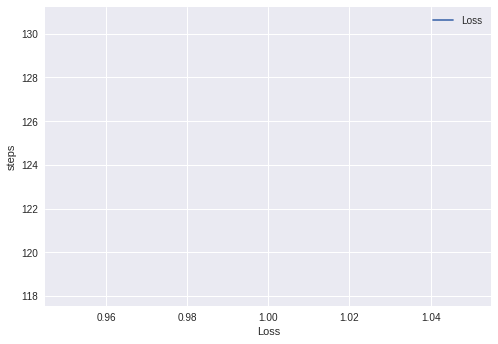

In [12]:

plt.plot(x, y, label="Loss")
plt.plot()

plt.xlabel("Loss")
plt.ylabel("steps")
plt.legend()
plt.show()

In [13]:
with graph3.as_default():
  inference_encoder_inputs = np.empty((real_hparams.encoder_length, real_hparams.batch_size), dtype=np.int)
  tweet = ["フォロー", "ありがとう", "メッセージ", "😢", "www"]
  tweet_ids = words_to_ids(tweet, vocab)
  tweet_ids.extend([pad_id] * (real_hparams.encoder_length - len(tweet_ids)))
  for i in range(real_hparams.batch_size):
    inference_encoder_inputs[:, i] = np.array(tweet_ids, dtype=np.int) 

  replies = model3.infer(inference_encoder_inputs)
  reply = replies[0].tolist()
  print("Infered reply", ids_to_words(reply, rev_vocab))
  
  beam_replies = model3.infer_beam_search(inference_encoder_inputs)
  print("Infered replies candidate0", ids_to_words(beam_replies[0][:,0], rev_vocab))
  print("Infered replies candidate1", ids_to_words(beam_replies[0][:,1], rev_vocab))

Infered reply _UNK_UNK_UNK_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_EOS
Infered replies candidate0 _UNK_UNK_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_EOS_EOS
Infered replies candidate1 _UNK_UNK_UNK_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_PAD_EOS_EOS


In [0]:
|